# MIDS W261 Spring 2016 Homework Week 2

Ron Cordell<br />
W261-4<br />
ron.cordell@ischool.berkeley.edu<br />
January 26, 2016

## HW2.0. 

### What is a race condition in the context of parallel computation? Give an example.

A race condition in parallel computing can happen when more than one instance of a procedure attempts to modify a shared object. For example, suppose there are two instances of a process that number with its square, and that both instances operate on the same number. There is nothing to control the actual timing of execution of these instances. If one instance of the process performs its work after the other instance then the answer will be the number raised to the 4th power and not the square. If both instances get the number, compute the square, one instance will write the number before the other, and the second one will overwrite the first. In this case, however, we get the correct answer. The problem is that we don't know deterministically which case will happen.

### What is MapReduce?

MapReduce is a two-stage functional programming recipe for processing large data sets.

- The first stage performs a computation over all inputs, called a 'map' from Lisp terminology
- The second stage aggregates the intermediate output from the first stage, called a 'reduce'

While seemingly simple, map reduce can be applied to a huge number of problems and can be used in multiple map-reduce stages for more complex scenarios. When a map function can be applied very simply using commutative and associative types of operations it lends to supporting embarrasingly parallel scenarios. While MapReduce has been around in functional programming languages like Lisp since the 1960's, it's modern use has come to the forefront as a result of a combination of commidity priced hardware compute and storage nodes and the [Google paper](http://static.googleusercontent.com/media/research.google.com/en//archive/mapreduce-osdi04.pdf).

### How does it differ from Hadoop?

Hadoop provides a framework in which to execute map-reduce and relieves the programmer of certain tasks while providing additional functionality. For example, Hadoop gathers and sorts the `(key,value)` pairs output by the mapper stage and routes them to the appropriate reducer, ensuring that each reducer has a complete set values for the keys given. This intermediate sort and route is part of the Hadoop Shuffle, which is the backbone of Hadoop.

### Which programming paradigm is Hadoop based on? Explain and give a simple example in code and show the code running.

Hadoop is based upon the map-reduce programming paradigm which is designed to allow parallel distributed processing of large sets of data by mapping/transforming them to sets of tuples then combining and reducing/aggregating them to smaller sets of tuples. The map and reduce steps are written by the user. 

What follows is a simple example of a map reduce application. The map and reduce steps are written in Python while the execution of the steps is executed by bash shell commands. This mapper and reducer count the number of occurances of a specified word in a text file.

#### MapReduce Simple Example

What follows is a simple example of a map reduce application. The map and reduce steps are written in Python while the execution of the steps is executed by bash shell commands. This mapper and reducer count the number of occurances of a specified word in a text file.

#### MapReduce Example - Map

This map step reads a file from the local disk line by line, then breaks each line down to individual words.
It then compares each word, ignoring case, to the specified search word and accumulates a count for that line. When all the lines have been examined the mapper writes the count to a file.

In [1]:
%%writefile mapper.py
#!/usr/bin/python
import sys
import re
count = 0
WORD_RE = re.compile(r"[\w']+")


# the word to find is the first argument
findword = sys.argv[1].lower()

# the file to scan is the second argument
filename = sys.argv[2]

# open the file, read it line by line
with open (filename, "r") as myfile:
    for line in myfile.readlines():
        
        # process each word in the line by filtering out non-words and if it matches
        # the search word, incrementing the word count
        for word in WORD_RE.findall(line):
            # make this a case-insensitve search
            if word.lower() == findword:
                count += 1
            
# now that we've counted this line, write out the count
with open ('{0}.intermediateCount'.format(filename),'w') as outfile:
    outfile.write('{0}\n'.format(count))

Overwriting mapper.py


In [21]:
# Set the appropriate execution mode on the file so we can execute it
!chmod a+x mapper.py

#### MapReduce Example - Reduce

The reduce step takes as input series of counts and accumulates them into a single count. The reducer recieves its input on STDIN and writes its output to STDOUT.

In [22]:
%%writefile reducer.py
#!/usr/bin/python
import sys
sum = 0
for line in sys.stdin:
    try:
        sum += int(line)
    except:
        pass
sys.stdout.write('{0}'.format(sum))

Overwriting reducer.py


In [23]:
# Set the appropriate execution mode on the file so we can execute it
!chmod a+x reducer.py

#### MapReduce Example - Putting it together

The following bash shell script takes the file to scan and breaks it into separate sub-files, each containing a chunk of the original file. It then invokes several instances of the mapper.py program, one for each chunk, and supplies one of the chunked files. The bash script waits for all mappers to finish and then It then takes the output files from each of the mapper.py programs and steams them one after the other to the reducer.py program.

The output of the MapReduce is the number of times a word has occurred in the file:

     found [59] [COPYRIGHT] in the file [LICENSE.txt]

In [24]:
%%writefile pGrepCount.sh
ORIGINAL_FILE=$1
FIND_WORD=$2
BLOCK_SIZE=$3
CHUNK_FILE_PREFIX=$ORIGINAL_FILE.split
SORTED_CHUNK_FILES=$CHUNK_FILE_PREFIX*.sorted
usage()
{
    echo Parallel grep
    echo usage: pGrepCount filename word chuncksize
    echo greps file file1 in $ORIGINAL_FILE and counts the number of lines
    echo Note: file1 will be split in chunks up to $ BLOCK_SIZE chunks each
    echo $FIND_WORD each chunk will be grepCounted in parallel
}
#Splitting $ORIGINAL_FILE INTO CHUNKS
split -b $BLOCK_SIZE $ORIGINAL_FILE $CHUNK_FILE_PREFIX
#DISTRIBUTE
for file in $CHUNK_FILE_PREFIX*
do
    #grep -i $FIND_WORD $file|wc -l >$file.intermediateCount &
    ./mapper.py $FIND_WORD $file >$file.intermediateCount &
done
wait
#MERGEING INTERMEDIATE COUNT CAN TAKE THE FIRST COLUMN AND TOTAL...
#numOfInstances=$(cat *.intermediateCount | cut -f 1 | paste -sd+ - |bc)
numOfInstances=$(cat *.intermediateCount | ./reducer.py)
echo "found [$numOfInstances] [$FIND_WORD] in the file [$ORIGINAL_FILE]"

Overwriting pGrepCount.sh


In [25]:
# set the permissions on the bash script so it can execute
!chmod a+x pGrepCount.sh

# execute the MapReduce example and output the result. We will look for the word 'assistance'
# the '4K' tells the bash script to break the original file down into chunks of no more than
# 4K bytes in size
!./pGrepCount.sh LICENSE.txt COPYRIGHT 4k


found [59] [COPYRIGHT] in the file [LICENSE.txt]


## HW2.1. Sort in Hadoop MapReduce

#### Given as input: Records of the form `<integer, “NA”>`, where integer is any integer, and “NA” is just the empty string.  Output: sorted key value pairs of the form `<integer, “NA”>` in decreasing order.  What happens if you have multiple reducers? Do you need additional steps? Explain.

If you have multiple reducers each one will have a locally sorted set of records but won't be able to coordinate with the other reducers to produce a complete sorted list. However, it is possible to customize a partitioner to partition the keys across reducers such that reducer 1 has the lowest key values, reducer 2 has the next lowest, and so on. Then the output of the reducers can be easily merged based on the number of the reducer. Technically this is an additional step. Another way to deal with multiple reducers is to have an additional step of taking the output of each of the reducers and sorting that into a single output.

#### Write code to generate N  random records of the form `<integer, “NA”>`. Let N = 10,000. Write the python Hadoop streaming map-reduce job to perform this sort. Display the top 10 biggest numbers. Display the 10 smallest numbers

### HW 2.1 - Record Generator

The `recordgneratory.py` accepts an argument to indicate the number of records to generate. Records are generated by selecting a random integer in the range of 1 to the maximum integer value allowed. That integer is appended with the string ",NA" and written to the output file as a record.

In [46]:
%%writefile recordgenerator.py
#!/usr/bin/python
import random
import sys

# get number of records to generate
num_records = int(sys.argv[1])

# generator function to create random integers in the range of 1 to sys.maxint
def gen(n):
    count = 0
    while count < n:
        yield (random.randint(1, sys.maxint))
        count += 1
        
# Generate a set of num_record key,value pairs with integer keys generated by the generator
# and write them to an output file in the form of "integer,NA"
for i in gen(num_records):
    sys.stdout.write('{0},{1}\n'.format(i,"NA"))

Overwriting recordgenerator.py


In [41]:
# Set the execution permissions of the Python script
!chmod a+x recordgenerator.py

### HW 2.1 - Map

For each line that is read from STDIN we expect a string in the form of:

     key,value

Write each `key, value` pair to STDOUT as `key<tab>value`

In [30]:
%%writefile mapper.py
#!/usr/bin/python
import sys

# each record comes via STDIN one record at a time
for record in sys.stdin:
    # clean whitespace and split at the comma
    k,v = record.strip().split(',')
    # write to STDOUT as key <tab> value
    print '{0}\t{1}'.format(k,v)

Overwriting mapper.py


In [31]:
# Set the execution permissions of the Python script
!chmod a+x mapper.py

### HW 2.1 - Reduce

For each `key<tab>value` read from STDIN write back out to STDOUT. The output is sorted because the input is already sorted for us by the record key, thanks to Hadoop.

In [51]:
%%writefile reducer.py
#!/usr/bin/python
import sys

# read each key,value pair from STDIN and write back out to STDOUT
# we can do this because the keys are sorted for us by Hadoop
for pair in sys.stdin:
    k,v = pair.strip().split('\t')
    print '{0}\t{1}'.format(k,v)

Overwriting reducer.py


In [52]:
# Set the execution permissions of the Python script
!chmod a+x reducer.py

### HW 2.1 - Test Code

Test the mapper and reducer by piping a small test set to the mapper, sort the output of the mapper based on the integer value (key), pipe the result to the reducer, then filter for the top 10 values.

In [57]:
!./recordgenerator.py 20 | ./mapper.py | sort -nr -k1,1 | ./reducer.py | head

8470506191635231078	NA
8026439827727903483	NA
7914562750245791116	NA
7866281371022919675	NA
7640348753853655778	NA
6499377995366904625	NA
5277692479661556743	NA
4708012296169908311	NA
4590245591349809339	NA
4346827061492181849	NA


### HW 2.1 - Running in Hadoop

#### Start Yarn and HDFS

In [58]:
!/usr/local/Cellar/hadoop/2.7.1/sbin/start-yarn.sh
!/usr/local/Cellar/hadoop/2.7.1/sbin/start-dfs.sh

starting yarn daemons
starting resourcemanager, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/yarn-rcordell-resourcemanager-Rons-iMac-Retina.local.out
localhost: no such identity: /Users/rcordell/.ssh/id_dsa: No such file or directory
localhost: Saving password to keychain failed
localhost: Identity added: /Users/rcordell/.ssh/id_rsa ((null))
localhost: starting nodemanager, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/yarn-rcordell-nodemanager-Rons-iMac-Retina.local.out
Starting namenodes on [localhost]
localhost: starting namenode, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/hadoop-rcordell-namenode-Rons-iMac-Retina.local.out
localhost: starting datanode, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/hadoop-rcordell-datanode-Rons-iMac-Retina.local.out
Starting secondary namenodes [0.0.0.0]
0.0.0.0: starting secondarynamenode, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/hadoop-rcordell-secondarynamenode-Rons-iMac-Retina.local.out


#### Create an HDFS folder

In [59]:
!hdfs dfs -mkdir -p /user/rcordell

#### Generate and upload record file containing 10000 records to HDFS

In [60]:
!./recordgenerator.py 10000 > records.txt
!hdfs dfs -put records.txt /user/rcordell

#### Hadoop Streaming Submission

     hadoop jar hadoopstreamingjarfile \
          -D stream.num.map.output.key.fields=n \
          -mapper mapperfile \
          -reducer reducerfile \
          -input inputfile \
          -output outputfile

Submit our MapReduce to Hadoop using Hadoop Streaming. Besides specifying the mapper, reducer, input file and output location, we also specify to use the KeyFieldBasedComparator and set the keycomparator options. This allows us to specify that the sorting will be done on the key field and to treat the key as a numeric value and to reverse sort (descending).

In [67]:
!hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
    -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
    -D mapreduce.partition.keycomparator.options=-nr \
    -mapper mapper.py \
    -reducer reducer.py \
    -input records.txt \
    -output recordsOutput

#### First 10 Items

The sorted records output of the MapReduce is on the HDFS file system in a file called `part-00000`. Let's look at the top 10 lines in the file, which should be the highest numbered records.

In [68]:
!hdfs dfs -cat /user/rcordell/recordsOutput/part-00000 | head

9223149662631926773	NA
9222462994771806812	NA
9221376548595256568	NA
9221200099560410483	NA
9216651204641081164	NA
9216610805780812765	NA
9215182420885073012	NA
9214763879526561081	NA
9214470163579875161	NA
9212397989479861727	NA
cat: Unable to write to output stream.


#### Last 10 Items

Now let's look at the last 10 items in the file, which should be the lowest record ids.

In [69]:
!hdfs dfs -cat /user/rcordell/recordsOutput/part-00000 | tail

9242791484899512	NA
8658217614831616	NA
7790490907682806	NA
7435515921714919	NA
4424418503692755	NA
4258466038084507	NA
3781763814522545	NA
3693207216031204	NA
2915017580505790	NA
1594448856056738	NA


#### Clean up HDFS output

In [70]:
!hdfs dfs -rm -r /user/rcordell/recordsOutput

Deleted /user/rcordell/recordsOutput


In [71]:
!hdfs dfs -rm /user/rcordell/records.txt

Deleted /user/rcordell/records.txt


#### Stop Yarn and HDFS

In [ ]:
!/usr/local/Cellar/hadoop/2.7.1/sbin/stop-yarn.sh
!/usr/local/Cellar/hadoop/2.7.1/sbin/stop-dfs.sh

## HW2.2.  WORDCOUNT

#### Using the Enron data from HW1 and Hadoop MapReduce streaming, write the mapper/reducer job that  will determine the word count (number of occurrences) of each white-space delimitted token (assume spaces, fullstops, comma as delimiters). Examine the word “assistance” and report its word count results.
 
CROSSCHECK: 
    >grep assistance enronemail_1h.txt|cut -d$'\t' -f4| grep assistance|wc -l    
     8    

#### NOTE  "assistance" occurs on 8 lines but how many times does the token occur? 10 times! This is the number we are looking for!

### HW2.2 - Map

Read from STDIN where each line read consists of tab-delimeted fields:
      
      id <tab> label <tab> subject <tab> body

For each word in the subject and body fields that matches the wordlist, emit a key,value pair of
      
      word, 1

In [23]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Ron Cordell
## Description: mapper code for HW2.2
## Read lines from STDIN, separate into fields
## Output a key, value => (word,count) for each word in the subject and body text

import sys
import re

WORD_RE = re.compile(r"[\w']+")

# extract words to count from first positional argument, making them all lower case
wordlist = []
if len(sys.argv) > 1:
    for word in sys.argv[1].strip().split():
        wordlist.append(word.lower())

## Lines in the file have 4 fields:
## ID \t SPAM \t SUBJECT \t CONTENT \n
for line in sys.stdin:
    try:
        # capture the id, label, subject and body
        email_id, label, subject, body = line.split('\t')
    except ValueError:
        # if there were only 3 fields in the input, assume field 3 is body
        email_id, label, body = line.split('\t')
        subject = ''
 
    # extract only words from the combined subject and body text
    for word in WORD_RE.findall(subject + ' ' + body):
        if len(wordlist) > 0:
            if word.lower() in wordlist:
                print('{0}\t{1}'.format(word.lower(), 1))
        else:
            # otherwise count all words
            print('{0}\t{1}'.format(word.lower(), 1))

Overwriting mapper.py


In [3]:
# Set the execution permissions of the Python script
!chmod a+x mapper.py

### HW 2.2 - Reduce

Read lines from STDIN of

      word, count
      
Accumulate the counts for each word and output the resulting word counts to STDOUT

In [4]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Ron Cordell
## Description: reducer code for HW2.2
## given a list of key,value pairs for word, count, aggregate and output the list
from operator import itemgetter
import sys

current_word = None
current_count = 0
word = None

# input comes from STDIN
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper.py
    word, count = line.split('\t', 1)

    # convert count (currently a string) to int
    try:
        count = int(count)
    except ValueError:
        # count was not a number, so silently
        # ignore/discard this line
        continue

    # this IF-switch only works because Hadoop sorts map output
    # by key (here: word) before it is passed to the reducer
    if current_word == word:
        current_count += count
    else:
        if current_word:
            # write result to STDOUT
            print '%s\t%s' % (current_word, current_count)
        current_count = count
        current_word = word

# do not forget to output the last word if needed!
if current_word == word:
    print '%s\t%s' % (current_word, current_count)

Overwriting reducer.py


In [5]:
# Set the execution permissions of the Python script
!chmod a+x reducer.py

### HW2.2 - Test

In [24]:
!cat enronemail_1h.txt | ./mapper.py "assistance master" | sort -k1,1 | ./reducer.py

assistance	10
master	3


### HW2.2 - Running in Hadoop

#### Start YARN and HDFS

In [ ]:
!/usr/local/Cellar/hadoop/2.7.1/sbin/start-yarn.sh
!/usr/local/Cellar/hadoop/2.7.1/sbin/start-dfs.sh

#### Create HDFS Folder

In [5]:
!hdfs dfs -mkdir -p /user/rcordell

#### Copy Enron email file to HDFS

In [12]:
!hdfs dfs -put enronemail_1h.txt /user/rcordell

put: `/user/rcordell/enronemail_1h.txt': File exists


#### Run Hadoop Job

In [13]:
!hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
    -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
    -D mapreduce.partition.keycomparator.options=-nr \
    -mapper "mapper.py 'assistance'" \
    -reducer reducer.py \
    -input enronemail_1h.txt \
    -output countsOutput

#### Examine output for 'assistance'

The output indicates the 10 occurances of the word assistance

In [14]:
!hdfs dfs -cat /user/rcordell/countsOutput/part-00000

assistance	10


### Clean up HDFS

In [15]:
!hdfs dfs -rm -r /user/rcordell/countsOutput

Deleted /user/rcordell/countsOutput


### Stop YARN and HDFS

In [ ]:
!/usr/local/Cellar/hadoop/2.7.1/sbin/stop-yarn.sh
!/usr/local/Cellar/hadoop/2.7.1/sbin/stop-dfs.sh

## HW2.2.1  

Using Hadoop MapReduce and your wordcount job (from HW2.2) determine the top-10 occurring tokens (most frequent tokens)

### Map

There is no need to make a change to the mapper, so we'll use the same mapper from HW2.2

### Reduce

The reducer is modified so that it sorts the resulting word accumulation and outputs the top 10 counts

In [25]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Ron Cordell
## Description: reducer code for HW2.2
## given a list of key,value pairs for word, count, aggregate and output the list
from operator import itemgetter
import sys

current_word = None
current_count = 0
word = None
all_words = []

# input comes from STDIN
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper.py
    word, count = line.split('\t', 1)

    # convert count (currently a string) to int
    try:
        count = int(count)
    except ValueError:
        # count was not a number, so silently
        # ignore/discard this line
        continue

    # this IF-switch only works because Hadoop sorts map output
    # by key (here: word) before it is passed to the reducer
    if current_word == word:
        current_count += count
    else:
        if current_word:
            # append result to list
            all_words.append((current_word, current_count))
        current_count = count
        current_word = word

# do not forget to output the last word if needed!
if current_word == word:
    all_words.append((current_word, current_count))
    
# sort the list by value
sorted_words = sorted(all_words, key=lambda pair: pair[1], reverse=True)

# write out the top 10
for i,word in enumerate(sorted_words):
    print '{0}\t{1}'.format(word[0],word[1])
    if i >= 10:
        break

Overwriting reducer.py


In [26]:
# Set the execution permissions of the Python script
!chmod a+x reducer.py

### Test

In [27]:
!cat enronemail_1h.txt | ./mapper.py | sort -k1,1 | ./reducer.py

the	1247
to	963
and	668
of	566
a	542
you	432
in	417
your	394
ect	382
for	373
on	271


## HW 2.2.1 - Running in Hadoop

#### Start YARN and HDFS

In [ ]:
!/usr/local/Cellar/hadoop/2.7.1/sbin/start-yarn.sh
!/usr/local/Cellar/hadoop/2.7.1/sbin/start-dfs.sh

#### Create HDFS Folder

In [28]:
!hdfs dfs -mkdir -p /user/rcordell

#### Copy Enron email file to HDFS

In [29]:
!hdfs dfs -put enronemail_1h.txt /user/rcordell

put: `/user/rcordell/enronemail_1h.txt': File exists


#### Run Hadoop Job

In [30]:
!hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
-mapper mapper.py \
-reducer reducer.py \
-input enronemail_1h.txt \
-output countsOutput

#### Top 10 Word Counts

The output agrees with our tests but it is apparent that it is mostly what one would consider "stop words". I also see 'ect' in the list which is interesting because it ranks so high. Looking at the source text it appears that 'ect' refers to a person who is referenced quite often in the Enron email samples.

In [31]:
!hdfs dfs -cat /user/rcordell/countsOutput/part-00000

the	1247
to	963
and	668
of	566
a	542
you	432
in	417
your	394
ect	382
for	373
on	271


#### Clean up HDFS

In [32]:
!hdfs dfs -rm -r /user/rcordell/countsOutput

Deleted /user/rcordell/countsOutput


### Stop YARN and HDFS

In [ ]:
!/usr/local/Cellar/hadoop/2.7.1/sbin/stop-yarn.sh
!/usr/local/Cellar/hadoop/2.7.1/sbin/stop-dfs.sh

## HW2.3. Multinomial NAIVE BAYES with NO Smoothing

Using the Enron data from HW1 and Hadoop MapReduce, write  a mapper/reducer job(s) that
   will both learn  Naive Bayes classifier and classify the Enron email messages using the learnt Naive Bayes classifier. Use all white-space delimitted tokens as independent input variables (assume spaces, fullstops, commas as delimiters). Note: for multinomial Naive Bayes, the Pr(X=“assistance”|Y=SPAM) is calculated as follows:

   the number of times “assistance” occurs in SPAM labeled documents / the number of words in documents labeled SPAM 

   E.g.,   “assistance” occurs 5 times in all of the documents Labeled SPAM, and the length in terms of the number of words in all documents labeled as SPAM (when concatenated) is 1,000. Then Pr(X=“assistance”|Y=SPAM) = 5/1000. Note this is a multinomial estimation of the class conditional for a Naive Bayes Classifier. No smoothing is needed in this HW. Multiplying lots of probabilities, which are between 0 and 1, can result in floating-point underflow. Since log(xy) = log(x) + log(y), it is better to perform all computations by summing logs of probabilities rather than multiplying probabilities. Please pay attention to probabilites that are zero! They will need special attention. Count up how many times you need to process a zero probabilty for each class and report. 

   Report the performance of your learnt classifier in terms of misclassifcation error rate of your multinomial Naive Bayes Classifier. Plot a histogram of the log posterior probabilities (i.e., log(Pr(Class|Doc))) for each class over the training set. Summarize what you see. 

   Error Rate = misclassification rate with respect to a provided set (say training set in this case). It is more formally defined here:

Let DF represent the evalution set in the following:
Err(Model, DF) = |{(X, c(X)) ∈ DF : c(X) != Model(x)}|   / |DF|

Where || denotes set cardinality; c(X) denotes the class of the tuple X in DF; and Model(X) denotes the class inferred by the Model “Model”





### HW 2.3 - Map Stage 1 - Term Mapper

In [374]:
%%writefile term_mapper.py
#!/usr/bin/python
## mapper.py
## Author: Ron Cordell
## Description: mapper code for HW2.3
## Given input on STDIN read lines and count occurrences of words
## Output a key, value => (token, email id, class, term_flag) = count

import sys
import re

## Lines in the file have 4 fields:
## ID \t SPAM \t SUBJECT \t CONTENT \n
WORD_RE = re.compile(r"[\w']+")

all_words = False
## Words in the word list are space delimited
## If no words specified, use all tokens as vocabulary terms
if len(sys.argv) > 1:
    wordlist = sys.argv[1].lower().split(' ')
else:
    all_words = True

# read each email as a line from stdin
for line in sys.stdin:
    try:
        # Split the line into the 4 fields
        email_id, label, subject, body = line.split('\t')
    except ValueError:
        # If there are 3 fields the assume the 3rd field is the body
        email_id, label, body = line.split('\t')
        subject = ''
    
    # extract only words from the combined subject and body text
    for token in WORD_RE.findall(subject + ' ' + body):
        # term indicates that this is a vocabulary word 
        # when not all words are considered this lets downstream processors know which are which
        term = '0'
        if all_words:
            term = '1'
        elif token.lower() in wordlist:
            term = '1'
            
        # emit on each word a key, value pair of [(word, id, label, term),1]
        # so that the sort function operates on the words as keys
        print('{0}\t{1}\t{2}\t{3}\t{4}'.format(token, email_id, label, term, 1))

Overwriting term_mapper.py


In [34]:
# Set the execution permissions of the Python script
!chmod a+x term_mapper.py

### HW2.3 - Reduce Stage 1 - Term Probabilities and Calculating the Naive Bayes model

The reducer calculates the naive bayes model from the training data mapped by the mapper. 
Each unique term is added to the model and the statistics updated when subsequent instances of the term are encountered. The model is a dictionary with the term as the key and the class counts and probabilities. When all input is processed, the model is persisted for use.

In [375]:
%%writefile probability_reducer.py
#!/usr/bin/python
## reducer.py
## Author: Ron Cordell
## Description: reducer code for HW1.4
## given a list of intermediate word count files, compute NB classification
import sys

term_counts = {}
spam_doc_ids = []
ham_doc_ids = []
spam_doc_word_count = 0.0
ham_doc_word_count = 0.0
spam_term_count = 0.0
ham_term_count = 0.0
terms = 0.0
current_key = None
current_count = 0

# STDIN consists of single lines of: token <tab> id <tab> class <tab> term_flag <tab> count
# Assume that the proper parameters have been set such that Hadoop knows to treat the first 4 fields
# as the key so that they are properly sorted when they reach the reducer
# See http://blog.cloudera.com/blog/2013/01/a-guide-to-python-frameworks-for-hadoop/ for an example

# perform the accumulation functions for each key, value received
def accumulate_key(key , _count, spam_doc_word_count, ham_doc_word_count, term_counts):
    # accumulate the key, values in a dictionary
    _token = key[0]
    _id = key[1]
    _label = key[2]
    _term = key[3]

    # accumulate into ham and spam dictionaries also
    if _label == '1':
        spam_doc_word_count += _count
        if _id not in spam_doc_ids:
            spam_doc_ids.append(_id)
        if _term == '1':
            if _token in term_counts:
                term_counts[_token]['spam_count'] += _count
            else:
                term_counts[_token] = {'spam_count' : _count,
                                     'ham_count' : 0.0,
                                      'prob_ham'  : 0.0,
                                      'prob_spam' : 0.0} 
    else:                
        ham_doc_word_count += _count
        if _id not in ham_doc_ids:
            ham_doc_ids.append(_id)
        if _term == '1':
            if _token in term_counts:
                term_counts[_token]['ham_count'] += _count
            else:
                term_counts[_token] = {'ham_count' : _count,
                                      'spam_count' : 0.0,
                                      'prob_ham'  : 0.0,
                                      'prob_spam' : 0.0}
    return spam_doc_word_count, ham_doc_word_count

# process the STDIN stream
for line in sys.stdin:
    # split the line into the key components and the value
    token, email_id, label, term, token_count = line.split('\t')

    # this makes reading the code a little easier
    if term == '0':
        vocab_word = False
    else:
        vocab_word = True

    # if we've been accumulating for this key, keep accumulating
    # this works because the input is sorted on the key
    if current_key == (token, email_id, label, term):
        current_count += int(token_count)
    else:
        # we've just received a different key from what we've been accumulating
        # wrap up with the current key
        if current_key:
            spam_doc_word_count, ham_doc_word_count = accumulate_key(current_key, 
                                                                     float(current_count), 
                                                                     spam_doc_word_count, 
                                                                     ham_doc_word_count, 
                                                                     term_counts)
        # start a new accumulation    
        current_count = int(token_count)
        current_key = (token, email_id, label, term)

# add the last key we've been accumulating
if current_key == (token, email_id, label, term):
    spam_doc_word_count, ham_doc_word_count = accumulate_key(current_key, 
                                                             float(current_count), 
                                                             spam_doc_word_count, 
                                                             ham_doc_word_count, 
                                                             term_counts)      
                       
# now we should have consolidated the intermediate counts and we can compute the rest

# count the number of terms
term_count = len(term_counts.keys()) * 1.0
# compute the prior
prior = (len(spam_doc_ids)*1.0)/(1.0*(len(spam_doc_ids) + len(ham_doc_ids)))

# calculate the P(term|class) for each term
# do not use smoothing here
for term in term_counts:
    term_counts[term]['prob_ham'] = (term_counts[term]['ham_count'])/(ham_doc_word_count + term_count)
    term_counts[term]['prob_spam'] = (term_counts[term]['spam_count'])/(spam_doc_word_count + term_count)
    
    # output term <tab> probability_ham <tab> ham_count <tab> probability_spam <tab> spam_count <tab> prior
    print '{0}\t{1}\t{2}\t{3}\t{4}\t{5}'.format(term, term_counts[term]['prob_ham'], 
                                           term_counts[term]['ham_count'],
                                           term_counts[term]['prob_spam'], 
                                           term_counts[term]['spam_count'], 
                                           prior)

Overwriting probability_reducer.py


In [39]:
# Set the execution permissions of the Python script
!chmod a+x probability_reducer.py

### HW2.3 - Test Stage 1 Map Reduce

In [240]:
!cat enronemail_1h.txt | ./term_mapper.py | sort -r -k1,1 | ./probability_reducer.py > term_probabilities.txt

### HW2.3 - Map Stage 2 - Email Classifier

Load in the Naive Bayes model which consists of each term, their relative counts and probabilities for each class.
Read the stdin stream where each line is an email with email_id, label, subject and body
Classify each email based on the log probabilities of each term
Omit terms from the calculation that don't have both - note: this can be made easier than I implemented it.
For each email, emit the id, label, class and log probabilities
At the end, emit the tallied zero probability counts for each class

In [384]:
%%writefile email_mapper.py
#!/usr/bin/python
## mapper.py
## Author: Ron Cordell
## Description: mapper code for HW2.3
## Given input on STDIN read lines and count occurrences of words
## Output a key, value => (token, email id, class, term_flag) = count

from math import log, exp
import sys
import re

prior = 0.0
zero_prob_ham = 0
zero_prob_spam = 0
terms = {}
# open the file with the term probabilities (model) and load into the terms dictionary
# each line in the file is 
#   term <tab> ham_probability <tab> ham_count <tab> spam_prob <tab> spam_count <tab> prior

# all values are floats

with open('term_probabilities.txt','r') as termfile:
    for line in termfile.readlines():
        term, ham_prob, ham_count, spam_prob, spam_count, _prior = line.strip().split('\t')
        terms[term.strip()] = {'ham_prob'  : float(ham_prob),  'ham_count'  : float(ham_count),
                       'spam_prob' : float(spam_prob), 'spam_count' : float(spam_count)}
        prior = float(_prior)

## Lines in the file have 4 fields:
## ID \t SPAM \t SUBJECT \t CONTENT \n
WORD_RE = re.compile(r"[\w']+")

# read each line from stdin, one email per line
for line in sys.stdin:
    log_prob_ham = log(1.0 - prior)
    log_prob_spam = log(prior)

    try:
        email_id, label, subject, body = line.split('\t')
    except ValueError:
        email_id, label, body = line.split('\t')
        subject = ''

    pred_label = None
        
    # extract only words from the combined subject and body text
    text = WORD_RE.findall(subject + ' ' + body)
    for token in text:
        t = token.strip().lower()
        if t in terms:
            # if we have a zero probability for either class conditional then add a minute value
            # to offset the effects
            if terms[t]['spam_prob'] > 0.0:
                log_prob_spam += log(terms[t]['spam_prob'])
                
                # if the term only occurs in spam, then mark this as spam and move on.
                if terms[t]['ham_prob'] <= 0.0:
                    pred_label = '1'
                    zero_prob_ham += 1
            if terms[t]['ham_prob'] > 0.0: 
                log_prob_ham += log(terms[t]['ham_prob'])
                
                # if we've only ever seen this term in ham, then mark as such and move on.
                if terms[t]['spam_prob'] <= 0.0:
                    pred_label = '0'
                    zero_prob_spam += 1

                    
    # if we didn't encounter a term that's not in one class then calculate the class
    if not pred_label:
        # We have what we need to classify the email
        # emit the classification
        if log_prob_spam > log_prob_ham:
            pred_label = '1'
        else:
            pred_label = '0'
            
    # for each email emit the id <tab> label <tab> prediction <tag> log_prob_ham <tab> log_prob_spam
    print '{0}\t{1}\t{2}\t{3}\t{4}'.format(email_id, label, pred_label, log_prob_ham, log_prob_spam)
    
# after all emails have been processed emit :<tab> zero ham probability count <tab> zero spam probability count
# the ':' lets the reducer know to treat it differently from the email classification
# pad out the end to keep the number of fields consistent
print ':\t{0}\t{1}\t{2}\t{3}'.format(zero_prob_ham, zero_prob_spam, ' ', ' ')

Overwriting email_mapper.py


In [87]:
# Set the execution permissions of the Python script
!chmod a+x email_mapper.py

### HW2.3 - Reduce Stage 2 - Email Classifier

Read each line from stdin which can be either an email classification or a zero probability tally.
Output the email classification and tally the error rate
Output the totaled zero probability counts for each class

In [377]:
%%writefile classifier_reducer.py
#!/usr/bin/python
## reducer.py
## Author: Ron Cordell
## Description: reducer code for HW1.4
## given a list of intermediate word count files, compute NB classification
import sys
from math import log,exp

zero_prob_ham = 0
zero_prob_spam = 0

right = 0
wrong = 0

# STDIN consists of lines of one of two kinds - one that starts with ':' and one that doesn't
# For the line that starts with a colon, accumulate the zero probability counts it has
# Otherwise the line is the email id, label, class, log probability ham, log probability spam

# Assume that the proper parameters have been set such that Hadoop knows to treat the first 4 fields
# as the key so that they are properly sorted when they reach the reducer
# See http://blog.cloudera.com/blog/2013/01/a-guide-to-python-frameworks-for-hadoop/ for an example

# process the STDIN stream
for line in sys.stdin:
    fields = line.strip().split('\t')
    
    # if this isn't a zero probability count 
    if fields[0] != ':':
        # output the email id, label, prediction
        print '{0}\t{1}\t{2}\t{3}\t{4}'.format(fields[0], fields[1], fields[2], fields[3], fields[4])
        
        # tally the error rate
        if fields[1].strip() != fields[2].strip():
            wrong += 1
        else:
            right += 1
    else:
        # this is actually the zero probability counters so tally them
        zero_prob_ham += int(fields[1])
        zero_prob_spam += int(fields[2])
    
print 'Error Rate: {0}/{1}'.format(wrong, right + wrong)
print 'Zero Probabilities: Spam {0} \tHam {1}'.format(zero_prob_spam, zero_prob_ham)

Overwriting classifier_reducer.py


In [50]:
# Set the execution permissions of the Python script
!chmod a+x classifier_reducer.py

### Test

Test with a small set of 10 lines of data

In [385]:
!cat enronemail_1h.txt | head | ./email_mapper.py | sort -k1,1 | ./classifier_reducer.py

cat: stdout: Broken pipe
0001.1999-12-10.farmer	0	0	-47.0290005534	-19.0617153626
0001.1999-12-10.kaminski	0	0	-30.7856476462	-21.9636085124
0001.2000-01-17.beck	0	0	-3809.99682474	-2361.1052968
0001.2000-06-06.lokay	0	0	-3830.76627631	-2691.51240111
0001.2001-02-07.kitchen	0	0	-352.34209308	-250.837517623
0001.2001-04-02.williams	0	0	-1428.65508644	-1083.39627997
0002.1999-12-13.farmer	0	0	-3046.27089855	-2131.56357157
0002.2001-02-07.kitchen	0	0	-466.724353395	-329.187502814
0002.2001-05-25.SA_and_HP	1	1	-410.383521205	-628.537594546
0002.2003-12-18.GP	1	1	-643.167996685	-1339.23830337
Error Rate: 0/10
Zero Probabilities: Spam 556 	Ham 107


## HW 2.3 - Processing With Hadoop

#### Start YARN and HDFS

In [ ]:
!/usr/local/Cellar/hadoop/2.7.1/sbin/start-yarn.sh
!/usr/local/Cellar/hadoop/2.7.1/sbin/start-dfs.sh

#### Create HDFS folders and copy files

In [66]:
!hdfs dfs -mkdir -p /user/rcordell
!hdfs dfs -put enronemail_1h.txt /user/rcordell

put: `/user/rcordell/enronemail_1h.txt': File exists


#### Clean up HDFS

Remove files for repested runs

In [386]:
!hdfs dfs -rm -r /user/rcordell/model
!hdfs dfs -rm -r /user/rcordell/classifier

Deleted /user/rcordell/model
Deleted /user/rcordell/classifier


#### Hadoop MR Stage 1 - Calculate the model

The Hadoop streaming input has two more parameters:

- jobconf stream.num.map.output.key.fields=4
- jobconf stream.num.reduce.output.key.fields=3

These are used to tell Hadoop which values in the tab-delimited key,value pairs make up the key. Otherwise Hadoop only uses the first field. This will give use more complete sorting control.

In [387]:
!hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
    -mapper term_mapper.py \
    -reducer probability_reducer.py \
    -input enronemail_1h.txt \
    -output model \
    -jobconf stream.num.map.output.key.fields=4 \
    -jobconf stream.num.reduce.output.key.fields=4

#### Copy model file to local file system from HDFS

In [388]:
!rm -f term_probabilities.txt
!hdfs dfs -get /user/rcordell/model/part-00000 term_probabilities.txt

#### Execute Hadoop Stage 2 MapReduce

Here we only want Hadoop to sort on the first field so we don't change the default behavior as we did in Stage 1.

In [389]:
!hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
    -mapper email_mapper.py \
    -reducer classifier_reducer.py \
    -input enronemail_1h.txt \
    -output classifier \
    -file term_probabilities.txt

packageJobJar: [term_probabilities.txt] [] /var/folders/z_/rfp5q2cd6db13d19v6yw0n8w0000gn/T/streamjob8125991547498805172.jar tmpDir=null


#### Examine the output of the classifier - Error Rate

The best I could get the error rate is 1% without Laplace Smoothing. 

In [390]:
!hdfs dfs -cat /user/rcordell/classifier/part-00000 | grep -i "error rate"

Error Rate: 1/100	


#### Zero Probability Counts

This is the count of how many zero probabilities were encountered for each class.

In [391]:
!hdfs dfs -cat /user/rcordell/classifier/part-00000 | grep -i "Zero Probabilities"

Zero Probabilities: Spam 4965 	Ham 5694


### HW 2.3 - Log Probability Distribution

The histograms below are a plot of the log probability distribution for both ham and spam classes.

The Ham histogram is must narrower than the Spam histogram. If we were working with normal distributions this would indicate the possibiliy increased power of the classifiers because spam may statistically significantly different from ham.

In [392]:
!rm classification_results.txt
!hdfs dfs -get /user/rcordell/classifier/part-00000 classification_results.txt

In [393]:
%matplotlib inline 

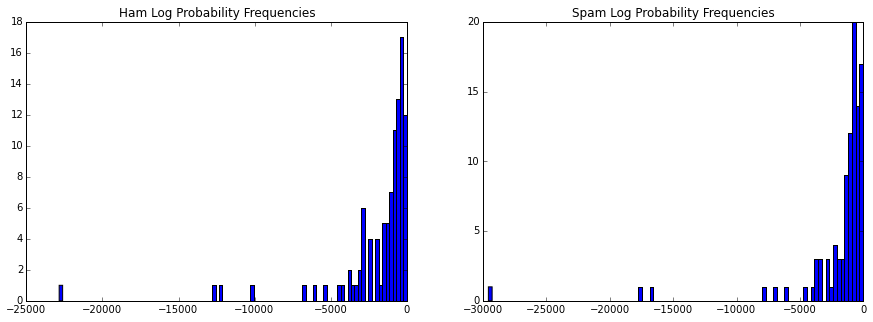

In [394]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
ham = []
spam = []
with open('classification_results.txt','r') as infile:
    for line in infile.readlines():
        try:
            _id, label, cls, lh, ls = line.strip().split('\t')
            try:
                ham.append(float(lh))
            except:
                ham.append(0.0)
            try:
                spam.append(float(ls))
            except:
                spam.append(0.0)
        except:
            pass

plt.figure(figsize=(15,5))
p = plt.subplot(1, 2, 1)
p.hist(ham,100)
plt.title('Ham Log Probability Frequencies')

p = plt.subplot(1, 2, 2)
p.hist(spam,100)
plt.title('Spam Log Probability Frequencies')     

### Clean up HDFS

In [395]:
!hdfs dfs -rm -r /user/rcordell/model
!hdfs dfs -rm -r /user/rcordell/classifier

Deleted /user/rcordell/model
Deleted /user/rcordell/classifier


## HW2.4 

Repeat HW2.3 with the following modification: use Laplace plus-one smoothing. Compare the misclassifcation error rates for 2.3 versus 2.4 and explain the differences.

For a quick reference on the construction of the Multinomial NAIVE BAYES classifier that you will code,
please consult the "Document Classification" section of the following wikipedia page:

https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Document_classification

OR the original paper by the curators of the Enron email data:

http://www.aueb.gr/users/ion/docs/ceas2006_paper.pdf



### HW 2.4 - Reduce Stage 1 - Add Smoothing

To implement Laplace smoothing we need to change the way the conditional probabilities are calculated in the first stage MapReduce so that the model is changed slightly. We don't need to make changes anywhere else so only the Stage 1 Reducer is shown here. The change is down near the bottom where the term conditional probabilities are calculated.


In [396]:
%%writefile probability_reducer.py
#!/usr/bin/python
## reducer.py
## Author: Ron Cordell
## Description: reducer code for HW1.4
## given a list of intermediate word count files, compute NB classification
import sys

term_counts = {}
spam_doc_ids = []
ham_doc_ids = []
spam_doc_word_count = 0.0
ham_doc_word_count = 0.0
spam_term_count = 0.0
ham_term_count = 0.0
terms = 0.0
current_key = None
current_count = 0

# STDIN consists of single lines of: token <tab> id <tab> class <tab> term_flag <tab> count
# Assume that the proper parameters have been set such that Hadoop knows to treat the first 4 fields
# as the key so that they are properly sorted when they reach the reducer
# See http://blog.cloudera.com/blog/2013/01/a-guide-to-python-frameworks-for-hadoop/ for an example

# perform the accumulation functions for each key, value received
def accumulate_key(key , _count, spam_doc_word_count, ham_doc_word_count, term_counts):
    # accumulate the key, values in a dictionary
    _token = key[0]
    _id = key[1]
    _label = key[2]
    _term = key[3]

    # accumulate into ham and spam dictionaries also
    if _label == '1':
        spam_doc_word_count += _count
        if _id not in spam_doc_ids:
            spam_doc_ids.append(_id)
        if _term == '1':
            if _token in term_counts:
                term_counts[_token]['spam_count'] += _count
            else:
                term_counts[_token] = {'spam_count' : _count,
                                     'ham_count' : 0.0,
                                      'prob_ham'  : 0.0,
                                      'prob_spam' : 0.0} 
    else:                
        ham_doc_word_count += _count
        if _id not in ham_doc_ids:
            ham_doc_ids.append(_id)
        if _term == '1':
            if _token in term_counts:
                term_counts[_token]['ham_count'] += _count
            else:
                term_counts[_token] = {'ham_count' : _count,
                                      'spam_count' : 0.0,
                                      'prob_ham'  : 0.0,
                                      'prob_spam' : 0.0}
    return spam_doc_word_count, ham_doc_word_count

# process the STDIN stream
for line in sys.stdin:
    # split the line into the key components and the value
    token, email_id, label, term, token_count = line.split('\t')

    # this makes reading the code a little easier
    if term == '0':
        vocab_word = False
    else:
        vocab_word = True

    # if we've been accumulating for this key, keep accumulating
    # this works because the input is sorted on the key
    if current_key == (token, email_id, label, term):
        current_count += int(token_count)
    else:
        # we've just received a different key from what we've been accumulating
        # wrap up with the current key
        if current_key:
            spam_doc_word_count, ham_doc_word_count = accumulate_key(current_key, 
                                                                     float(current_count), 
                                                                     spam_doc_word_count, 
                                                                     ham_doc_word_count, 
                                                                     term_counts)
        # start a new accumulation    
        current_count = int(token_count)
        current_key = (token, email_id, label, term)

# add the last key we've been accumulating
if current_key == (token, email_id, label, term):
    spam_doc_word_count, ham_doc_word_count = accumulate_key(current_key, 
                                                             float(current_count), 
                                                             spam_doc_word_count, 
                                                             ham_doc_word_count, 
                                                             term_counts)      
                       
# now we should have consolidated the intermediate counts and we can compute the rest

# count the number of terms
term_count = len(term_counts.keys()) * 1.0
# compute the prior
prior = (len(spam_doc_ids)*1.0)/(1.0*(len(spam_doc_ids) + len(ham_doc_ids)))

# calculate the P(term|class) for each term
# IMPLEMENT LAPLACE +1 SMOOTHING HERE
for term in term_counts:
    term_counts[term]['prob_ham'] = (term_counts[term]['ham_count'] + 1)/(ham_doc_word_count + term_count)
    term_counts[term]['prob_spam'] = (term_counts[term]['spam_count'] + 1)/(spam_doc_word_count + term_count)
    
    # output term <tab> probability_ham <tab> ham_count <tab> probability_spam <tab> spam_count <tab> prior
    print '{0}\t{1}\t{2}\t{3}\t{4}\t{5}'.format(term, term_counts[term]['prob_ham'], 
                                           term_counts[term]['ham_count'],
                                           term_counts[term]['prob_spam'], 
                                           term_counts[term]['spam_count'], 
                                           prior)

Overwriting probability_reducer.py


#### Test

Quick sanity check to make sure we didn't break something...

In [397]:
!cat enronemail_1h.txt | ./term_mapper.py | sort -r -k1,1 | ./probability_reducer.py > term_probabilities.txt
!cat enronemail_1h.txt | head | ./email_mapper.py | sort -k1,1 | ./classifier_reducer.py

cat: stdout: Broken pipe
0001.1999-12-10.farmer	0	0	-44.207621667	-48.5150042289
0001.1999-12-10.kaminski	0	0	-29.8576689636	-31.6972485272
0001.2000-01-17.beck	0	0	-3717.60394613	-4306.64332295
0001.2000-06-06.lokay	0	0	-3744.50706598	-4162.88761835
0001.2001-02-07.kitchen	0	0	-345.886680666	-403.404749371
0001.2001-04-02.williams	0	0	-1388.79498638	-1426.89990274
0002.1999-12-13.farmer	0	0	-2978.22974162	-3473.16767374
0002.2001-02-07.kitchen	0	0	-451.556869828	-463.833433441
0002.2001-05-25.SA_and_HP	1	1	-668.372602902	-610.88070367
0002.2003-12-18.GP	1	1	-1420.003234	-1296.97743047
Error Rate: 0/10
Zero Probabilities: Spam 0 	Ham 0


## HW2.4 - Processing With Hadoop

It is assumed that the hadoop processes are still running

#### Clean up HDFS

In [398]:
!hdfs dfs -rm -r /user/rcordell/model
!hdfs dfs -rm -r /user/rcordell/classifier

rm: `/user/rcordell/model': No such file or directory
rm: `/user/rcordell/classifier': No such file or directory


#### Hadoop Stage 1 MapReduce with Smoothing

The Hadoop streaming input has two more parameters:

- jobconf stream.num.map.output.key.fields=4
- jobconf stream.num.reduce.output.key.fields=3

These are used to tell Hadoop which values in the tab-delimited key,value pairs make up the key. Otherwise Hadoop only uses the first field. This will give use more complete sorting control.

In [399]:
!hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
    -mapper term_mapper.py \
    -reducer probability_reducer.py \
    -input enronemail_1h.txt \
    -output model \
    -jobconf stream.num.map.output.key.fields=4 \
    -jobconf stream.num.reduce.output.key.fields=4

#### Copy model file to local file system from HDFS

In [400]:
!rm -f term_probabilities.txt
!hdfs dfs -get /user/rcordell/model/part-00000 term_probabilities.txt

#### Execute Hadoop Stage 2 MapReduce

Here we only want Hadoop to sort on the first field so we don't change the default behavior as we did in Stage 1.

In [401]:
!hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
    -mapper email_mapper.py \
    -reducer classifier_reducer.py \
    -input enronemail_1h.txt \
    -output classifier \
    -file term_probabilities.txt

packageJobJar: [term_probabilities.txt] [] /var/folders/z_/rfp5q2cd6db13d19v6yw0n8w0000gn/T/streamjob3208978509498932952.jar tmpDir=null


#### Examine the output of the classifier - Error Rate

In [402]:
!hdfs dfs -cat /user/rcordell/classifier/part-00000 | grep -i "error rate"

Error Rate: 0/100	


#### Zero Probability Counts

This is the count of how many zero probabilities were encountered for each class. Notice how there are now no zero probabilities for either class as a result of the Laplace Smoothing

In [403]:
!hdfs dfs -cat /user/rcordell/classifier/part-00000 | grep -i "Zero Probabilities"

Zero Probabilities: Spam 0 	Ham 0


### HW 2.4 - Log Probability Distribution

The histograms below are a plot of the log probability distribution for both ham and spam classes.

Now the histograms are much more similar in appearance and not nearly as much noticeable difference. The magnitudes are also more similar with the Ham being a couple of orders of magnitude larger than the spam.

In [405]:
# get the classification results from HDFS
!rm classification_results.txt
!hdfs dfs -get /user/rcordell/classifier/part-00000 classification_results.txt

In [345]:
%matplotlib inline 

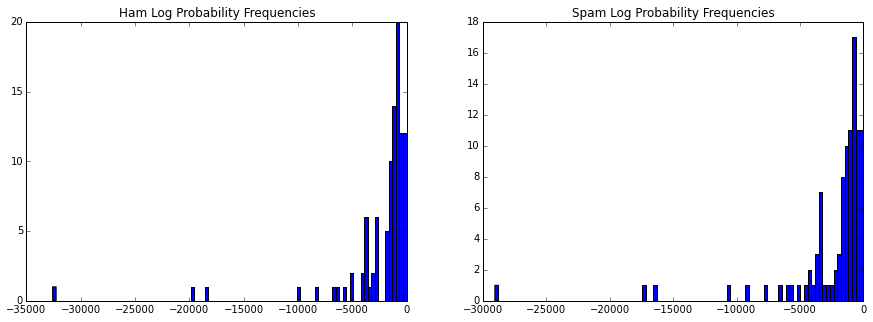

In [406]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
ham = []
spam = []
with open('classification_results.txt','r') as infile:
    for line in infile.readlines():
        try:
            _id, label, cls, lh, ls = line.strip().split('\t')
            try:
                ham.append(float(lh))
            except:
                ham.append(0.0)
            try:
                spam.append(float(ls))
            except:
                spam.append(0.0)
        except:
            pass

plt.figure(figsize=(15,5))
p = plt.subplot(1, 2, 1)
p.hist(ham,100)
plt.title('Ham Log Probability Frequencies')

p = plt.subplot(1, 2, 2)
p.hist(spam,100)
plt.title('Spam Log Probability Frequencies')     

### Clean up HDFS

In [407]:
!hdfs dfs -rm -r /user/rcordell/model
!hdfs dfs -rm -r /user/rcordell/classifier

Deleted /user/rcordell/model
Deleted /user/rcordell/classifier


## HW2.5. 

Repeat HW2.4. This time when modeling and classification ignore tokens with a frequency of less than three (3) in the training set. How does it affect the misclassifcation error of learnt naive multinomial Bayesian Classifier on the training dataset:

### HW 2.5 - Reducer Stage 1, +1 Smoothing, Term Counts >= 3

Once again we only need to make changes to the Stage 1 Reducer where the model conditional probabilities are calculated.

In [408]:
%%writefile probability_reducer.py
#!/usr/bin/python
## reducer.py
## Author: Ron Cordell
## Description: reducer code for HW1.4
## given a list of intermediate word count files, compute NB classification
import sys

term_counts = {}
spam_doc_ids = []
ham_doc_ids = []
spam_doc_word_count = 0.0
ham_doc_word_count = 0.0
spam_term_count = 0.0
ham_term_count = 0.0
terms = 0.0
current_key = None
current_count = 0

# STDIN consists of single lines of: token <tab> id <tab> class <tab> term_flag <tab> count
# Assume that the proper parameters have been set such that Hadoop knows to treat the first 4 fields
# as the key so that they are properly sorted when they reach the reducer
# See http://blog.cloudera.com/blog/2013/01/a-guide-to-python-frameworks-for-hadoop/ for an example

# perform the accumulation functions for each key, value received
def accumulate_key(key , _count, spam_doc_word_count, ham_doc_word_count, term_counts):
    # accumulate the key, values in a dictionary
    _token = key[0]
    _id = key[1]
    _label = key[2]
    _term = key[3]

    # accumulate into ham and spam dictionaries also
    if _label == '1':
        spam_doc_word_count += _count
        if _id not in spam_doc_ids:
            spam_doc_ids.append(_id)
        if _term == '1':
            if _token in term_counts:
                term_counts[_token]['spam_count'] += _count
            else:
                term_counts[_token] = {'spam_count' : _count,
                                     'ham_count' : 0.0,
                                      'prob_ham'  : 0.0,
                                      'prob_spam' : 0.0} 
    else:                
        ham_doc_word_count += _count
        if _id not in ham_doc_ids:
            ham_doc_ids.append(_id)
        if _term == '1':
            if _token in term_counts:
                term_counts[_token]['ham_count'] += _count
            else:
                term_counts[_token] = {'ham_count' : _count,
                                      'spam_count' : 0.0,
                                      'prob_ham'  : 0.0,
                                      'prob_spam' : 0.0}
    return spam_doc_word_count, ham_doc_word_count

# process the STDIN stream
for line in sys.stdin:
    # split the line into the key components and the value
    token, email_id, label, term, token_count = line.split('\t')

    # this makes reading the code a little easier
    if term == '0':
        vocab_word = False
    else:
        vocab_word = True

    # if we've been accumulating for this key, keep accumulating
    # this works because the input is sorted on the key
    if current_key == (token, email_id, label, term):
        current_count += int(token_count)
    else:
        # we've just received a different key from what we've been accumulating
        # wrap up with the current key
        if current_key:
            spam_doc_word_count, ham_doc_word_count = accumulate_key(current_key, 
                                                                     float(current_count), 
                                                                     spam_doc_word_count, 
                                                                     ham_doc_word_count, 
                                                                     term_counts)
        # start a new accumulation    
        current_count = int(token_count)
        current_key = (token, email_id, label, term)

# add the last key we've been accumulating
if current_key == (token, email_id, label, term):
    spam_doc_word_count, ham_doc_word_count = accumulate_key(current_key, 
                                                             float(current_count), 
                                                             spam_doc_word_count, 
                                                             ham_doc_word_count, 
                                                             term_counts)      
                       
# now we should have consolidated the intermediate counts and we can compute the rest

# count the number of terms
term_count = len(term_counts.keys()) * 1.0
# compute the prior
prior = (len(spam_doc_ids)*1.0)/(1.0*(len(spam_doc_ids) + len(ham_doc_ids)))

# calculate the P(term|class) for each term

# HW 2.4 - IMPLEMENT LAPLACE +1 SMOOTHING HERE
# HW 2.5 - IMPLEMENT MIN 3 TERM COUNT HERE

terms_to_drop = []
for term in term_counts:
    # if either the spam or ham term count is > 3, keep this term in the model
    if term_counts[term]['ham_count'] >= 3 or term_counts[term]['spam_count'] >= 3:
        term_counts[term]['prob_ham'] = (term_counts[term]['ham_count'] + 1)/(ham_doc_word_count + term_count)
        term_counts[term]['prob_spam'] = (term_counts[term]['spam_count'] + 1)/(spam_doc_word_count + term_count)
    else:
        # add the term to be removed to the list; we can't remove it while iterating over the dictionary
        terms_to_drop.append(term)

for term in terms_to_drop:
    term_counts.pop(term, None)  

# now emit the model
for term in term_counts:
    # output term <tab> probability_ham <tab> ham_count <tab> probability_spam <tab> spam_count <tab> prior
    print '{0}\t{1}\t{2}\t{3}\t{4}\t{5}'.format(term, term_counts[term]['prob_ham'], 
                                           term_counts[term]['ham_count'],
                                           term_counts[term]['prob_spam'], 
                                           term_counts[term]['spam_count'], 
                                           prior)


Overwriting probability_reducer.py


#### Test

Quick sanity check to make sure we didn't break something...

In [409]:
!cat enronemail_1h.txt | ./term_mapper.py | sort -r -k1,1 | ./probability_reducer.py > term_probabilities.txt
!cat enronemail_1h.txt | head | ./email_mapper.py | sort -k1,1 | ./classifier_reducer.py

cat: stdout: Broken pipe
0001.1999-12-10.farmer	0	0	-16.6201146096	-18.92818397
0001.1999-12-10.kaminski	0	0	-20.6618332778	-21.6039260474
0001.2000-01-17.beck	0	0	-2906.60280384	-3408.87707355
0001.2000-06-06.lokay	0	0	-3193.69771685	-3561.12355773
0001.2001-02-07.kitchen	0	0	-293.1444572	-344.231108854
0001.2001-04-02.williams	0	0	-1044.21881162	-1052.19466281
0002.1999-12-13.farmer	0	0	-2441.35194768	-2883.61228998
0002.2001-02-07.kitchen	0	0	-324.031565551	-326.803584842
0002.2001-05-25.SA_and_HP	1	1	-463.882016539	-415.909813035
0002.2003-12-18.GP	1	1	-908.548713672	-814.655756641
Error Rate: 0/10
Zero Probabilities: Spam 0 	Ham 0


## HW2.5 - Processing With Hadoop

It is assumed that the hadoop processes are still running

#### Clean up HDFS

In [410]:
!hdfs dfs -rm -r /user/rcordell/model
!hdfs dfs -rm -r /user/rcordell/classifier

rm: `/user/rcordell/model': No such file or directory
rm: `/user/rcordell/classifier': No such file or directory


#### Hadoop Stage 1 MapReduce with Smoothing

The Hadoop streaming input has two more parameters:

- jobconf stream.num.map.output.key.fields=4
- jobconf stream.num.reduce.output.key.fields=3

These are used to tell Hadoop which values in the tab-delimited key,value pairs make up the key. Otherwise Hadoop only uses the first field. This will give use more complete sorting control.

In [411]:
!hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
    -mapper term_mapper.py \
    -reducer probability_reducer.py \
    -input enronemail_1h.txt \
    -output model \
    -jobconf stream.num.map.output.key.fields=4 \
    -jobconf stream.num.reduce.output.key.fields=4

#### Copy model file to local file system from HDFS

In [412]:
!rm -f term_probabilities.txt
!hdfs dfs -get /user/rcordell/model/part-00000 term_probabilities.txt

#### Execute Hadoop Stage 2 MapReduce

Here we only want Hadoop to sort on the first field so we don't change the default behavior as we did in Stage 1.

In [413]:
!hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
    -mapper email_mapper.py \
    -reducer classifier_reducer.py \
    -input enronemail_1h.txt \
    -output classifier \
    -file term_probabilities.txt

packageJobJar: [term_probabilities.txt] [] /var/folders/z_/rfp5q2cd6db13d19v6yw0n8w0000gn/T/streamjob5789292786380840881.jar tmpDir=null


#### Examine the output of the classifier - Error Rate

The error rate has increased to 4% with the addition of removing terms with counts < 3 from the model. That indicates that those terms carried enough information to make a difference in the classification rate.

The classifier doesn't consider tokens that are not in the vocabulary, so they do not contribute to the calculation of the document class.

In [414]:
!hdfs dfs -cat /user/rcordell/classifier/part-00000 | grep -i "error rate"

Error Rate: 4/100	


#### Zero Probability Counts

This is the count of how many zero probabilities were encountered for each class. Notice how there are now no zero probabilities for either class as a result of the Laplace Smoothing

In [415]:
!hdfs dfs -cat /user/rcordell/classifier/part-00000 | grep -i "Zero Probabilities"

Zero Probabilities: Spam 0 	Ham 0


### HW 2.5 - Log Probability Distribution

The histograms below are a plot of the log probability distribution for both ham and spam classes.

There doesn't seem to be much change from the Laplace smoothing histograms.

In [416]:
# Get classification output file from HDFS
!rm classification_results.txt
!hdfs dfs -get /user/rcordell/classifier/part-00000 classification_results.txt

In [366]:
%matplotlib inline 

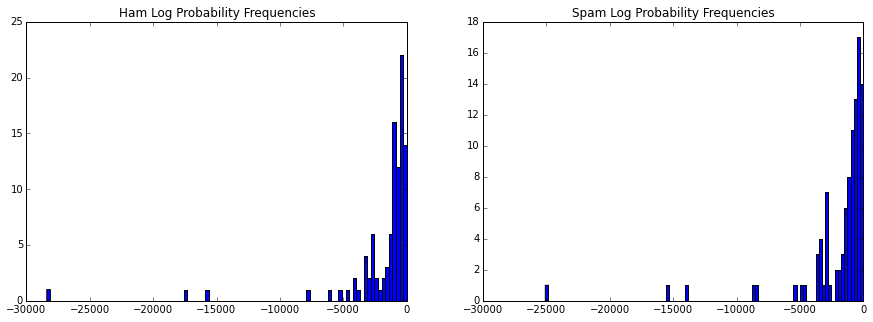

In [417]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
ham = []
spam = []
with open('classification_results.txt','r') as infile:
    for line in infile.readlines():
        try:
            _id, label, cls, lh, ls = line.strip().split('\t')
            try:
                ham.append(float(lh))
            except:
                ham.append(0.0)
            try:
                spam.append(float(ls))
            except:
                spam.append(0.0)
        except:
            pass

plt.figure(figsize=(15,5))
p = plt.subplot(1, 2, 1)
p.hist(ham,100)
plt.title('Ham Log Probability Frequencies')

p = plt.subplot(1, 2, 2)
p.hist(spam,100)
plt.title('Spam Log Probability Frequencies')     

### Clean up HDFS

In [418]:
!hdfs dfs -rm -r /user/rcordell/model

Deleted /user/rcordell/model


In [419]:
!hdfs dfs -rm -r /user/rcordell/classifier

Deleted /user/rcordell/classifier


### Stop Yarn and HDFS

In [423]:
!/usr/local/Cellar/hadoop/2.7.1/sbin/stop-yarn.sh
!/usr/local/Cellar/hadoop/2.7.1/sbin/stop-dfs.sh

stopping yarn daemons
stopping resourcemanager
localhost: stopping nodemanager
localhost: nodemanager did not stop gracefully after 5 seconds: killing with kill -9
no proxyserver to stop
Stopping namenodes on [localhost]
localhost: stopping namenode
localhost: stopping datanode
Stopping secondary namenodes [0.0.0.0]
0.0.0.0: stopping secondarynamenode


## HW2.6 

Benchmark your code with the Python SciKit-Learn implementation of the multinomial Naive Bayes algorithm

It always a good idea to benchmark your solutions against publicly available libraries such as SciKit-Learn, The Machine Learning toolkit available in Python. In this exercise, we benchmark ourselves against the SciKit-Learn implementation of multinomial Naive Bayes.  For more information on this implementation see: http://scikit-learn.org/stable/modules/naive_bayes.html more  

In this exercise, please complete the following:

— Run the Multinomial Naive Bayes algorithm (using default settings) from SciKit-Learn over the same training data used in HW2.5 and report the misclassification error (please note some data preparation might be needed to get the Multinomial Naive Bayes algorithm from SkiKit-Learn to run over this dataset)
- Prepare a table to present your results, where rows correspond to approach used (SkiKit-Learn versus your Hadoop implementation) and the column presents the training misclassification error
— Explain/justify any differences in terms of training error rates over the dataset in HW2.5 between your Multinomial Naive Bayes implementation (in Map Reduce) versus the Multinomial Naive Bayes implementation in SciKit-Learn 

### HW 2.6 - Scikit-Learn Naive Bayes


In [420]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

X_train = []
Y_train = []

# replicate our mapper code here where we take the subject and body together
# except now we grab the label field as well to use for the Y values
with open('enronemail_1h.txt', 'rU') as infile:
    for line in infile.readlines():
        try:
            email_id, label, subject, body = line.split('\t')
            X_train.append(subject + ' ' + body)
        except ValueError:
            email_id, label, body = line.split('\t')
            X_train.append(body)
        # extract only words from the combined subject and body text
        Y_train.append(int(label))

# Use the TfidVectorizer to create the feature vectors
# We should override the tokenizer regular expression to make it the same as what we used
# in our poor man's mapper code
vectorizer = TfidfVectorizer(token_pattern = "[\w']+")
vf = vectorizer.fit(X_train,Y_train)

### HW 2.6 - Multinomial Bayes Training Error

In [421]:
clf = MultinomialNB()
clf.fit(vf.fit_transform(X_train), Y_train)
print 1.0 - clf.score(vf.fit_transform(X_train), Y_train)

0.0


### HW 2.6 - Results

The following table summarizes our results of the various classification method training error. The difference between the HW 2.5 Multinomial NB classifier and the Scikit Learn is that the term vectorizor using the Scikit learn uses all terms, whereas the HW2.5 version does not.

| Classification Methodology  | Training error |
|-----------------------------|----------------|
| Multinomial NB no smoothing    |      1%       |
| Multinomial NB Laplace +1 smoothing  |      0%       |
| Multinomial NB Smoothing & Term Count >= 3  |      4%        |
| scikit-learn MultinomialNB  |      0%        |
| scikit-learn BernoulliNB    |     18%        |

## HW 2.6.1 OPTIONAL (note this exercise is a stretch HW and optional)

—  Run the Bernoulli Naive Bayes algorithm from SciKit-Learn (using default settings) over the same training data used in HW2.6 and report the misclassification error 
-  Discuss the performance differences in terms of misclassification error rates over the dataset in HW2.5 between the  Multinomial Naive Bayes implementation in SciKit-Learn with the  Bernoulli Naive Bayes implementation in SciKit-Learn. Why such big differences. Explain. 

Which approach to Naive Bayes would you recommend for SPAM detection? Justify your selection.

### HW 2.6.1 - Bernoulli Bayes Training Error

In [422]:
clf = BernoulliNB()
clf.fit(vf.fit_transform(X_train), Y_train)
print 1.0 - clf.score(vf.fit_transform(X_train), Y_train)

0.18


## HW2.7 OPTIONAL (note this exercise is a stretch HW and optional)

The Enron SPAM data in the following folder enron1-Training-Data-RAW is in raw text form (with subfolders for SPAM and HAM that contain raw email messages in the following form:

--- Line 1 contains the subject
--- The remaining lines contain the body of the email message.

In Python write a script to produce a TSV file called train-Enron-1.txt that has a similar format as the enronemail_1h.txt that you have been using so far. Please pay attend to funky characters and tabs. Check your resulting formated email data in Excel and in Python (e.g., count up the number of fields in each row; the number of SPAM mails and the number of HAM emails). Does each row correspond to an email record with four values? Note: use "NA" to denote empty field values.

## HW2.8 OPTIONAL
Using Hadoop Map-Reduce write job(s) to perform the following:
 -- Train a multinomial Naive Bayes Classifier with Laplace plus one smoothing using the data extracted in HW2.7 (i.e., train-Enron-1.txt). Use all white-space delimitted tokens as independent input variables (assume spaces, fullstops, commas as delimiters). Drop tokens with a frequency of less than three (3).
 -- Test the learnt classifier using enronemail_1h.txt and report the misclassification error rate. Remember to use all white-space delimitted tokens as independent input variables (assume spaces, fullstops, commas as delimiters). How do we treat tokens in the test set that do not appear in the training set?

## HW2.8.1 OPTIONAL
—  Run  both the Multinomial Naive Bayes and the Bernoulli Naive Bayes algorithms from SciKit-Learn (using default settings) over the same training data used in HW2.8 and report the misclassification error on both the training set and the testing set
- Prepare a table to present your results, where rows correspond to approach used (SciKit-Learn Multinomial NB; SciKit-Learn Bernouili NB; Your Hadoop implementation)  and the columns presents the training misclassification error, and the misclassification error on the test data set
-  Discuss the performance differences in terms of misclassification error rates over the test and training datasets by the different implementations. Which approch (Bernouili versus Multinomial) would you recommend for SPAM detection? Justify your selection.